# Logistics Performance & Customer Satisfaction — Olist E-commerce

This notebook analyzes late deliveries in Olist’s e-commerce dataset and evaluates their impact on customer satisfaction (review scores).  
It also identifies priority regions (Brazilian states) where operational improvements could reduce delays and improve customer experience.

## 1. Setup and data ingestion

Load the original Olist CSV files into pandas DataFrames and perform a quick profiling check (shape, missing values, duplicates).

In [1]:
from pathlib import Path
import pandas as pd

DATA_RAW = Path("../01_data/raw")

In [2]:
files = {
    "orders": "olist_orders_dataset.csv",
    "items": "olist_order_items_dataset.csv",
    "payments": "olist_order_payments_dataset.csv",
    "reviews": "olist_order_reviews_dataset.csv",
    "products": "olist_products_dataset.csv",
    "customers": "olist_customers_dataset.csv",
    "sellers": "olist_sellers_dataset.csv",
    "geolocation": "olist_geolocation_dataset.csv",
    "category_translation": "product_category_name_translation.csv",
}

dfs = {}
for name, fname in files.items():
    path = DATA_RAW / fname
    dfs[name] = pd.read_csv(path)
    print(f"{name}: {dfs[name].shape}")

orders: (99441, 8)
items: (112650, 7)
payments: (103886, 5)
reviews: (99224, 7)
products: (32951, 9)
customers: (99441, 5)
sellers: (3095, 4)
geolocation: (1000163, 5)
category_translation: (71, 2)


In [3]:
def quick_profile(df, name):
    print(f"\n== {name} ==")
    print("rows/cols:", df.shape)
    print("nulls top:\n", df.isna().sum().sort_values(ascending=False).head(10))
    print("dupes:", df.duplicated().sum())

for name, df in dfs.items():
    quick_profile(df, name)


== orders ==
rows/cols: (99441, 8)
nulls top:
 order_delivered_customer_date    2965
order_delivered_carrier_date     1783
order_approved_at                 160
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_estimated_delivery_date       0
dtype: int64
dupes: 0

== items ==
rows/cols: (112650, 7)
nulls top:
 order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64
dupes: 0

== payments ==
rows/cols: (103886, 5)
nulls top:
 order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64
dupes: 0

== reviews ==
rows/cols: (99224, 7)
nulls top:
 review_comment_title       87656
review_comment_message     58247
review_id                      0
order_id                      

## 2. Orders preparation and logistics KPI definition

Convert timestamp columns to datetime and define a logistics KPI: `delivered_late`, which flags whether a delivered order arrived after the estimated delivery date.

In [4]:
orders = dfs["orders"].copy()
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
orders.shape, list(orders.columns)

((99441, 8),
 ['order_id',
  'customer_id',
  'order_status',
  'order_purchase_timestamp',
  'order_approved_at',
  'order_delivered_carrier_date',
  'order_delivered_customer_date',
  'order_estimated_delivery_date'])

In [6]:
date_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in date_cols:
    orders[col] = pd.to_datetime(orders[col])

orders[date_cols].dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [7]:
orders["delivered_late"] = (
    orders["order_delivered_customer_date"] > orders["order_estimated_delivery_date"]
)

orders[
    ["order_delivered_customer_date", "order_estimated_delivery_date", "delivered_late"]
].head(10)

,order_delivered_customer_date,order_estimated_delivery_date,delivered_late
0,2017-10-10 21:25:13,2017-10-18,False
1,2018-08-07 15:27:45,2018-08-13,False
2,2018-08-17 18:06:29,2018-09-04,False
3,2017-12-02 00:28:42,2017-12-15,False
4,2018-02-16 18:17:02,2018-02-26,False
5,2017-07-26 10:57:55,2017-08-01,False
6,NaT,2017-05-09,False
7,2017-05-26 12:55:51,2017-06-07,False
8,2017-02-02 14:08:10,2017-03-06,False
9,2017-08-16 17:14:30,2017-08-23,False


In [8]:
round(orders["delivered_late"].mean() * 100, 2)

np.float64(7.87)

## 3. Validate KPI scope (delivered orders only)

Late delivery is only meaningful for delivered orders. Validate behavior across order statuses and then focus the analysis on `order_status == "delivered"`.

In [9]:
late_by_status = (
    orders.groupby("order_status")["delivered_late"]
    .mean()
    .sort_values(ascending=False)
)

(late_by_status * 100).round(2)

order_status
delivered      8.11
canceled       0.16
approved       0.00
created        0.00
invoiced       0.00
processing     0.00
shipped        0.00
unavailable    0.00
Name: delivered_late, dtype: float64

In [10]:
delivered_orders = orders[orders["order_status"] == "delivered"].copy()
round(delivered_orders["delivered_late"].mean() * 100, 2)

np.float64(8.11)

## 4. Monthly trend of late deliveries

Create a monthly time dimension based on purchase timestamp and compute late delivery rate over time.

In [11]:
delivered_orders["order_month"] = delivered_orders["order_purchase_timestamp"].dt.to_period("M")

late_by_month = (
    delivered_orders.groupby("order_month")["delivered_late"]
    .mean()
)

late_by_month_pct = (late_by_month * 100).round(2)
late_by_month_pct

order_month
2016-09    100.00
2016-10      1.13
2016-12      0.00
2017-01      3.07
2017-02      3.21
2017-03      5.58
2017-04      7.86
2017-05      3.61
2017-06      3.86
2017-07      3.43
2017-08      3.32
2017-09      5.20
2017-10      5.29
2017-11     14.31
2017-12      8.38
2018-01      6.56
2018-02     15.99
2018-03     21.36
2018-04      5.31
2018-05      8.24
2018-06      1.36
2018-07      4.48
2018-08     10.39
Freq: M, Name: delivered_late, dtype: float64

<Axes: title={'center': 'Late delivery rate by month (delivered orders)'}, xlabel='Month', ylabel='% late deliveries'>

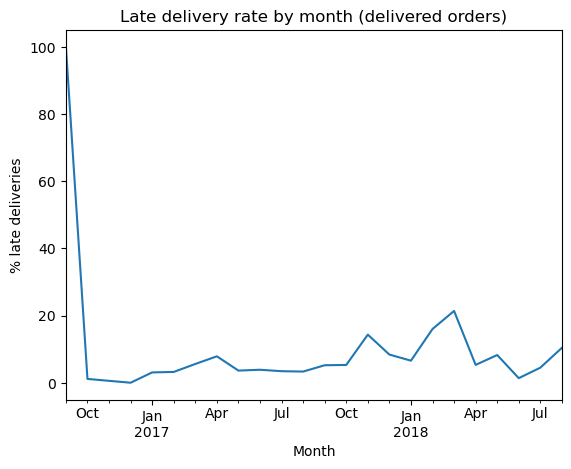

In [12]:
late_by_month_pct.plot(
    title="Late delivery rate by month (delivered orders)",
    ylabel="% late deliveries",
    xlabel="Month",
)

## 5. Customer satisfaction impact (reviews)

Join delivered orders with customer review scores and compare average ratings between on-time vs late deliveries.

In [13]:
reviews = dfs["reviews"].copy()

reviews_simple = reviews[["order_id", "review_score"]].copy()
reviews_simple.head()

,order_id,review_score
0,73fc7af87114b39712e6da79b0a377eb,4
1,a548910a1c6147796b98fdf73dbeba33,5
2,f9e4b658b201a9f2ecdecbb34bed034b,5
3,658677c97b385a9be170737859d3511b,5
4,8e6bfb81e283fa7e4f11123a3fb894f1,5


In [14]:
orders_reviews = delivered_orders.merge(
    reviews_simple,
    on="order_id",
    how="left"
)

orders_reviews["review_score"].isna().mean() * 100

np.float64(0.6659313245435896)

In [15]:
review_by_delay = (
    orders_reviews.groupby("delivered_late")
    .agg(
        avg_review=("review_score", "mean"),
        orders_count=("order_id", "count"),
    )
)

review_by_delay

,avg_review,orders_count
delivered_late,,
False,4.293737,89142
True,2.566494,7865


## 6. Regional prioritization (customer state)

Join customer location (state) and prioritize regions based on:
- late delivery rate
- average review score
- order volume (minimum sample threshold)

In [16]:
customers = dfs["customers"].copy()
customers_simple = customers[["customer_id", "customer_state"]].copy()
customers_simple.head()

,customer_id,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,SP
1,18955e83d337fd6b2def6b18a428ac77,SP
2,4e7b3e00288586ebd08712fdd0374a03,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,SP


In [17]:
orders_reviews_geo = orders_reviews.merge(
    customers_simple,
    on="customer_id",
    how="left"
)

state_summary = (
    orders_reviews_geo.groupby("customer_state")
    .agg(
        orders_count=("order_id", "count"),
        late_rate=("delivered_late", "mean"),
        avg_review=("review_score", "mean"),
    )
    .assign(
        late_rate_pct=lambda d: (d["late_rate"] * 100).round(2),
        avg_review_round=lambda d: d["avg_review"].round(2),
    )
)

state_focus = state_summary[state_summary["orders_count"] >= 1000].copy()

state_focus.sort_values(
    by=["late_rate_pct", "avg_review_round"],
    ascending=[False, True]
).head(10)

,orders_count,late_rate,avg_review,late_rate_pct,avg_review_round
customer_state,,,,,
CE,1282,0.153666,3.938088,15.37,3.94
BA,3273,0.140849,3.929452,14.08,3.93
RJ,12420,0.134783,3.963439,13.48,3.96
ES,2004,0.122255,4.082406,12.23,4.08
PE,1604,0.107232,4.085535,10.72,4.09
SC,3560,0.097753,4.131050,9.78,4.13
GO,1974,0.082067,4.102904,8.21,4.10
RS,5382,0.071721,4.185496,7.17,4.19
DF,2099,0.070986,4.131642,7.10,4.13


## 7. Export final tables for Power BI

Export finalized, analysis-ready tables to be used directly in Power BI (no raw data required in the repo).

In [18]:
late_by_month_export = (
    delivered_orders.groupby("order_month")["delivered_late"]
    .mean()
    .reset_index()
)

late_by_month_export = late_by_month_export.assign(
    late_rate_pct=(late_by_month_export["delivered_late"] * 100).round(2)
)

late_by_month_export.head()

,order_month,delivered_late,late_rate_pct
0,2016-09,1.000000,100.00
1,2016-10,0.011321,1.13
2,2016-12,0.000000,0.00
3,2017-01,0.030667,3.07
4,2017-02,0.032063,3.21


In [19]:
OUTPUT_DIR = Path("../04_outputs/tables")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

review_by_delay.to_csv(OUTPUT_DIR / "review_by_delivery_delay.csv", index=True)

state_focus.sort_values(
    by=["late_rate_pct", "avg_review_round"],
    ascending=[False, True]
).to_csv(OUTPUT_DIR / "state_priority_logistics.csv", index=True)

late_by_month_export.to_csv(OUTPUT_DIR / "monthly_late_delivery_trend.csv", index=False)

print("Exports completed:", list(OUTPUT_DIR.glob("*.csv")))

Exports completed: [WindowsPath('../04_outputs/tables/monthly_late_delivery_trend.csv'), WindowsPath('../04_outputs/tables/review_by_delivery_delay.csv'), WindowsPath('../04_outputs/tables/state_priority_logistics.csv')]
